# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [19]:
!pip install pyvin

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [21]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from pyvin import VIN as vin
from category_encoders import TargetEncoder  # Import TargetEncoder

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn import set_config
set_config(display="diagram")

import xgboost as xgb


In [22]:
pip install xgboost


In [23]:
pip install category_encoders

In [24]:
# Load the vehicles.csv file
cars_df = pd.read_csv('/Users/luzejames/Documents/Python/M11/practical_application_II_starter/data/vehicles.csv')

In [25]:

# Shuffle the DataFrame rows
shuffled_cars_df = cars_df.sample(frac=1).reset_index(drop=True)

# Slice the DataFrame 
#cars_df = shuffled_cars_df.iloc[0:100000, 0:]  


In [26]:
# Look for null values and data types
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [27]:
cars_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [28]:
# Empty rows, without any information these rows are useles. I will drop them

columns_to_check = ['VIN', 'manufacturer', 'model', 'condition', 'fuel', 'type']  
records_with_nan = cars_df[cars_df[columns_to_check].isna().all(axis=1)] 

#Drop all rows that don't have any meaningful data
cars_df.drop(records_with_nan.index, inplace=True)

In [29]:
# By exploring the data, I found many duplicates. I am going to drop them before continuing with any other processing

records_with_null_VIN = cars_df[cars_df['VIN'].isna()]
records_with_non_null_VIN = cars_df[cars_df['VIN'].notna()]
records_with_non_null_VIN = records_with_non_null_VIN.drop_duplicates(subset='VIN')

# Combine the two DataFrames
cars_df = pd.concat([records_with_null_VIN, records_with_non_null_VIN], ignore_index=True)

# Count the records
cars_df.describe()

,id,price,year,odometer
count,2.792200e+05,2.792200e+05,278627.000000,2.759940e+05
mean,7.312040e+09,1.023865e+05,2009.511975,1.133672e+05
std,4.249052e+06,1.506272e+07,10.656351,2.599018e+05
min,7.301583e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.309206e+09,4.650000e+03,2007.000000,5.258925e+04
50%,7.313439e+09,9.995000e+03,2012.000000,1.000000e+05
75%,7.315506e+09,1.998800e+04,2016.000000,1.460000e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [30]:
# I used a VIN library to update makes, models and year based on the VIN. So, I ran the dataframe in a separate notebook because it look
# a long time. 
# After running the cars_df dataframe through that VIN library, I was able to gather data such as Manufacturer, Model and ModelYear 
# for some VINs. I downloaded that information into the following csv file.

VINData = pd.read_csv('/Users/luzejames/Documents/Python/M11/practical_application_II_starter/data/VINData.csv')
#VINData = pd.read_csv('/Users/ljames/Documents/Python/M11/practical_application_II_starter/data/VINData.csv')

VINData.describe()
VINData.head()

,VIN,Make,Model,ModelYear
0,SCBCR63W16C030477,BENTLEY,Continental,2006
1,1BAKDCPA3GF313137,BLUE BIRD,BB Conventional,2016
2,3MW5R1J08L8B21625,BMW,330i,2020
3,1GYS4CKJ2KR309076,CADILLAC,Escalade,2019
4,1GYKNERSXJZ160440,CADILLAC,XT5,2018


In [31]:
# The following process cleans the data of the records that were found by the VIN library. It updated Manufacturer, Model and Year

import pandas as pd

def clean_data(value):
    """Cleans the data by trimming spaces at the beginning and end if the value is a string."""
    if isinstance(value, str):
        return value.strip()
    return value

def update_car_info(cars_df, VINData, chunksize=50000):
    """
    Updates the 'manufacturer', 'model', and 'year' columns in the cars_df based on mappings in VINData,
    matching on VIN.
    Modifies cars_df in place.

    Args:
        cars_df: DataFrame with car data, including 'VIN', 'manufacturer', 'model', and 'year' columns.
        VINData: DataFrame with mappings between VIN and car information.
                 Must contain 'VIN', 'Make', 'Model', and 'ModelYear' columns.
        chunksize: (Optional) The number of rows to process at a time.
                  If None, process the entire DataFrame at once.

    Returns:
        The updated cars_df (the original cars_df is also modified in place).
    """
    if not all(col in VINData.columns for col in ['VIN', 'Make', 'Model', 'ModelYear']):
        raise KeyError(
            "VINData must contain 'VIN', 'Make', 'Model', and 'ModelYear' columns."
        )

    # Clean the VINData
    VINData['VIN'] = VINData['VIN'].apply(clean_data)
    VINData['Make'] = VINData['Make'].apply(clean_data)
    VINData['Model'] = VINData['Model'].apply(clean_data)
    VINData['ModelYear'] = VINData['ModelYear'].apply(clean_data)

    # Clean the cars_df
    cars_df['VIN'] = cars_df['VIN'].apply(clean_data)
    cars_df['manufacturer'] = cars_df['manufacturer'].apply(clean_data)
    cars_df['model'] = cars_df['model'].apply(clean_data)
    cars_df['year'] = cars_df['year'].apply(clean_data)

    if chunksize is None:
        # Process the entire DataFrame at once
        for index, row in cars_df.iterrows():
            if clean_data(row['VIN']) in VINData['VIN'].values:
                print(f"Updating row {index}: {row['VIN']}")  # Debugging print statement
                cars_df.at[index, 'manufacturer'] = VINData.loc[VINData['VIN'] == clean_data(row['VIN']), 'Make'].values[0]
                cars_df.at[index, 'model'] = VINData.loc[VINData['VIN'] == clean_data(row['VIN']), 'Model'].values[0]
                cars_df.at[index, 'year'] = VINData.loc[VINData['VIN'] == clean_data(row['VIN']), 'ModelYear'].values[0]

    else:
        # Process the DataFrame in chunks
        for i in range(0, len(cars_df), chunksize):
            chunk = cars_df.iloc[i:i + chunksize].copy()  # Create a copy of the chunk
            for index, row in chunk.iterrows():
                if clean_data(row['VIN']) in VINData['VIN'].values:
  #                  print(f"Updating chunk row {index}: {row['VIN']}")  # Debugging print statement
                    chunk.at[index, 'manufacturer'] = VINData.loc[VINData['VIN'] == clean_data(row['VIN']), 'Make'].values[0]
                    chunk.at[index, 'model'] = VINData.loc[VINData['VIN'] == clean_data(row['VIN']), 'Model'].values[0]
                    chunk.at[index, 'year'] = VINData.loc[VINData['VIN'] == clean_data(row['VIN']), 'ModelYear'].values[0]
            cars_df.iloc[i:i + chunksize] = chunk  # Update the original DataFrame with the modified chunk

    return cars_df


if __name__ == "__main__":

    # Process in chunks of 50000
    updated_cars_df = update_car_info(cars_df, VINData, chunksize=50000)
  


In [32]:
# Working on Normalization 
# I loaded all manufacturers and models into a new dataset called 'models' and added a column with the normalized model name
# Load the models.csv file

models_df = pd.read_csv('/Users/luzejames/Documents/Python/M11/practical_application_II_starter/data/models.csv')
#models_df = pd.read_csv('/Users/ljames/Documents/Python/M11/practical_application_II_starter/data/models.csv')


models_df['oldmodel'] = models_df['oldmodel'].str.upper()
models_df['manufacturer'] = models_df['manufacturer'].str.upper()
models_df['newmodel'] = models_df['newmodel'].str.upper()

cars_df['manufacturer'] = cars_df['manufacturer'].str.upper()
cars_df['model'] = cars_df['model'].str.upper()


In [33]:
models_df.head()

,Numb,manufacturer,oldmodel,newmodel
0,0,ACURA,ILX,ILX
1,1,ACURA,ILX 2.0L SEDAN 4D,ILX
2,2,ACURA,ILX PREMIUM PKG SEDAN 4D,ILX
3,3,ACURA,ILX SEDAN 4D,ILX
4,4,ACURA,MDX,MDX


In [34]:
cars_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7316356412,auburn,15000,2013.0,FORD,F-150 XLT,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al
1,7316285779,auburn,35000,2019.0,TOYOTA,TACOMA,excellent,6 cylinders,gas,43000.0,clean,automatic,NaN,4wd,NaN,truck,grey,al
2,7316130053,auburn,4500,1992.0,JEEP,CHEROKEE,excellent,6 cylinders,gas,192000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
3,7315039307,auburn,0,2011.0,JEEP,COMPASS,excellent,NaN,gas,99615.0,clean,automatic,NaN,NaN,full-size,SUV,NaN,al
4,7314560853,auburn,19900,2004.0,FORD,F250 SUPER DUTY,good,8 cylinders,diesel,88000.0,clean,automatic,NaN,4wd,full-size,pickup,blue,al


In [35]:
#Records where manufacturer is null and the model is either 'ALL MAKES' or 'other'
# These records will be dropped because this data has not been properly captured and it is useless
no_meaningful_makes_or_models = cars_df[((cars_df['model'] == 'ALL MAKES') | (cars_df['model'] == 'other')) & (cars_df['manufacturer'].isnull())]
cars_df.drop(no_meaningful_makes_or_models.index, inplace = True)

In [36]:
cars_df.describe()

,id,price,year,odometer
count,2.791370e+05,2.791370e+05,278568.000000,2.759110e+05
mean,7.312041e+09,1.024167e+05,2009.510644,1.133808e+05
std,4.248578e+06,1.506495e+07,10.657093,2.599380e+05
min,7.301583e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.309208e+09,4.680000e+03,2007.000000,5.259800e+04
50%,7.313440e+09,9.995000e+03,2012.000000,1.000000e+05
75%,7.315506e+09,1.998800e+04,2016.000000,1.460000e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [37]:
# This process updates manufacturer and model names for some rows based on the models dataframe

def clean_data(value):
    """I was having a hard time with the matching process. So, this process was created to trim blank spaces at the beginning and end if the value is a string."""
    if isinstance(value, str):
        return value.strip()
    return value

def update_car_models(cars_df, models_df, chunksize=50000):
    if not all(col in models_df.columns for col in ['manufacturer', 'oldmodel', 'newmodel']):
        raise KeyError(
            "models_df must contain 'manufacturer', 'oldmodel', and 'newmodel' columns."
        )

    # Clean the models_df
    models_df['manufacturer'] = models_df['manufacturer'].apply(clean_data)
    models_df['oldmodel'] = models_df['oldmodel'].apply(clean_data)
    models_df['newmodel'] = models_df['newmodel'].apply(clean_data)

    # Clean the cars_df
    cars_df['manufacturer'] = cars_df['manufacturer'].apply(clean_data)
    cars_df['model'] = cars_df['model'].apply(clean_data)

    # Create a copy to avoid modifying models_df directly.
    models_df_merge = models_df.rename(columns={'newmodel': 'model', 'oldmodel': 'old_model'}).copy() 
    
    if chunksize is None:
        # Process the entire DataFrame at once
        cars_df['model'] = cars_df.apply(
            lambda row: models_df_merge.loc[
                (models_df_merge['manufacturer'] == clean_data(row['manufacturer'])) & 
                (models_df_merge['old_model'] == clean_data(row['model'])),  
                'model'
            ].values[0]
            if clean_data(row['manufacturer']) in models_df_merge['manufacturer'].values and
            any(models_df_merge.loc[
                (models_df_merge['manufacturer'] == clean_data(row['manufacturer'])) & 
                (models_df_merge['old_model'] == clean_data(row['model'])), 
                'model'
            ].values)
            else clean_data(row['model']),
            axis=1
        )

    else:
        # Process the DataFrame in chunks
        for i in range(0, len(cars_df), chunksize):
            chunk = cars_df.iloc[i:i + chunksize].copy()  # Create a copy of the chunk
            chunk['model'] = chunk.apply(
                lambda row: models_df_merge.loc[
                    (models_df_merge['manufacturer'] == clean_data(row['manufacturer'])) &
                    (models_df_merge['old_model'] == clean_data(row['model'])), 
                    'model'
                ].values[0]
                if clean_data(row['manufacturer']) in models_df_merge['manufacturer'].values and
                any(models_df_merge.loc[
                    (models_df_merge['manufacturer'] == clean_data(row['manufacturer'])) &
                    (models_df_merge['old_model'] == clean_data(row['model'])), 
                    'model'
                ].values)
                else clean_data(row['model']),
                axis=1
            )
            cars_df.iloc[i:i + chunksize] = chunk  # Update the original DataFrame with the modified chunk

    return cars_df

if __name__ == "__main__":

    # Process in chunks of 50000
    updated_cars_df = update_car_models(cars_df, models_df, chunksize=50000)
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 279137 entries, 0 to 279219
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            279137 non-null  int64  
 1   region        279137 non-null  object 
 2   price         279137 non-null  int64  
 3   year          278568 non-null  float64
 4   manufacturer  266404 non-null  object 
 5   model         274866 non-null  object 
 6   condition     162400 non-null  object 
 7   cylinders     173482 non-null  object 
 8   fuel          277436 non-null  object 
 9   odometer      275911 non-null  float64
 10  title_status  275434 non-null  object 
 11  transmission  277871 non-null  object 
 12  VIN           118246 non-null  object 
 13  drive         193250 non-null  object 
 14  size          98374 non-null   object 
 15  type          198068 non-null  object 
 16  paint_color   187361 non-null  object 
 17  state         279137 non-null  object 
dtypes: float6

In [38]:
# Drop records where 'manufacturer' is null and 'model' is NOT null
# After reviewing, these records are useless.
null_manufacturer_not_null_model = cars_df[cars_df['manufacturer'].isnull() & cars_df['model'].notnull()]
cars_df[cars_df['manufacturer'].isnull() & cars_df['model'].notnull()]


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
15,7306198330,auburn,6800,2005.0,NaN,BLUE BIRD BUS,excellent,6 cylinders,diesel,180000.0,clean,automatic,NaN,rwd,full-size,bus,yellow,al
16,7305082143,auburn,2500,1966.0,NaN,1966 C-30 1 TON,good,6 cylinders,gas,47000.0,clean,manual,NaN,rwd,full-size,pickup,brown,al
22,7316873897,birmingham,5900,2001.0,NaN,F-350,NaN,8 cylinders,diesel,200000.0,clean,automatic,NaN,rwd,NaN,NaN,NaN,al
52,7316423933,birmingham,53000,2006.0,NaN,STERLING ACTERRA,NaN,NaN,diesel,160322.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
64,7316211151,birmingham,0,2014.0,NaN,FREIGHTLINER CASCADIA,NaN,NaN,diesel,100.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278874,7307911359,milwaukee,12995,2013.0,NaN,GMCE SIERRA,excellent,8 cylinders,gas,150690.0,clean,automatic,1GTR2VE78DZ229760,4wd,NaN,NaN,grey,wi
278954,7315478843,sheboygan,7450,1976.0,NaN,CORVETTE COUPE,good,8 cylinders,gas,60193.0,clean,manual,1Z37L6S418690,rwd,NaN,coupe,NaN,wi
279069,7313868777,wausau,11899,1991.0,NaN,CHEV. CAMARO RS,excellent,8 cylinders,gas,42000.0,clean,automatic,1G1FP23E4ML145760,rwd,mid-size,coupe,green,wi
279159,7305281414,wausau,5400,1995.0,NaN,OLDSMOBILE CUTLASS SUPREME,good,6 cylinders,gas,82000.0,clean,automatic,1G3WT32X45D315683,fwd,mid-size,convertible,white,wi


In [39]:
# Drop records that don't have any data for manufacturer and model
more_records_to_drop = cars_df[cars_df['manufacturer'].isnull() & cars_df['model'].isnull()]
cars_df.drop(more_records_to_drop.index, inplace = True)


In [40]:
# There are a lot of records whose Model is either 'ALL MAKES', 'Other' or 'ALL' and the other columns have no information. 
# These records will be dropped

# Checking for rows without data
records_with_nulls = cars_df[((cars_df['model'] == 'ALL MAKES') | (cars_df['model'] == 'other')  | (cars_df['model'] == 'ALL')) & (cars_df['manufacturer'].isnull())]

# Print the records with NaN values
print("Records with no meaningful information :")
print(records_with_nulls)

# Drop these records
cars_df.drop(records_with_nulls.index, inplace=True)

Records with no meaningful information :
                id           region  price    year manufacturer model  \
625     7315563641           dothan      1  2012.0          NaN   ALL   
1791    7307571890       tuscaloosa     24  2020.0          NaN   ALL   
3255    7316727942          phoenix    999  1901.0          NaN   ALL   
6825    7316876099      little rock    500  2020.0          NaN   ALL   
7671    7309310422      little rock    500  2020.0          NaN   ALL   
...            ...              ...    ...     ...          ...   ...   
149502  7312306322  charlottesville      0  2020.0          NaN   ALL   
150080  7312308853     harrisonburg      0  2019.0          NaN   ALL   
150236  7312308085        lynchburg      0  2020.0          NaN   ALL   
151904  7312306763         richmond      0  2020.0          NaN   ALL   
172536  7316740981    inland empire      1  1900.0          NaN   ALL   

       condition cylinders   fuel  odometer title_status transmission  VIN  \
625 

In [41]:
# Update 'manufacturer' column based on 'model' 

cars_df['manufacturer'] = cars_df.apply(lambda row: 'SCION' if pd.isnull(row['manufacturer']) and 'SCION' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'GENESIS' if pd.isnull(row['manufacturer']) and 'GENESIS' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'GMC' if pd.isnull(row['manufacturer']) and 'HUMMER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FREIGHTLINER' if pd.isnull(row['manufacturer']) and 'FREIGHTLINER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'MASERATI' if pd.isnull(row['manufacturer']) and 'MASERATI GHIBLI' in str(row['model']) else row['manufacturer'], axis=1)

cars_df['manufacturer'] = cars_df.apply(lambda row: 'ISUZU' if pd.isnull(row['manufacturer']) and 'ISUZU' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'ISUZU' if (row['manufacturer']=='FORD') and 'ISUZU' in str(row['model']) else row['manufacturer'], axis=1)

cars_df['manufacturer'] = cars_df.apply(lambda row: 'NAVISTAR' if pd.isnull(row['manufacturer']) and 'INTERNATIONAL 4300' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'SAAB' if pd.isnull(row['manufacturer']) and 'SAAB' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'MERCEDES BENZ' if pd.isnull(row['manufacturer']) and 'SMART FORTWO' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'WORKHORSE' if pd.isnull(row['manufacturer']) and 'WORKHORSE' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'NAVISTAR' if pd.isnull(row['manufacturer']) and 'INTERNATIONAL TERRASTAR' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'DODGE' if pd.isnull(row['manufacturer']) and 'GRAND CARAVAN' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'HINO' if pd.isnull(row['manufacturer']) and 'HINO 268' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'GMC' if pd.isnull(row['manufacturer']) and 'OLDSMOBILE' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'BLUE BIRD' if pd.isnull(row['manufacturer']) and 'BLUE BIRD' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'INTERNATIONAL' if pd.isnull(row['manufacturer']) and str(row['model']) =='INTERNATIONAL' else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'INTERNATIONAL' if pd.isnull(row['manufacturer']) and str(row['model']) =='INTERNATIONAL 4700' else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'SUZUKI' if pd.isnull(row['manufacturer']) and 'SUZUKI' in str(row['model']) else row['manufacturer'], axis=1)

cars_df['manufacturer'] = cars_df.apply(lambda row: 'FORD' if pd.isnull(row['manufacturer']) and str(row['model']) == 'F150 XLT CREW CAB' else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FORD' if pd.isnull(row['manufacturer']) and str(row['model']) == 'FOR THUNDERBIRD' else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FORD' if pd.isnull(row['manufacturer']) and str(row['model']) == 'FOR F-250' else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FORD' if pd.isnull(row['manufacturer']) and str(row['model']) == 'F-150' else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'MERCEDES BENZ' if pd.isnull(row['manufacturer']) and str(row['model']) =='DES-BENZ CLA' else row['manufacturer'], axis=1)



In [42]:
cars_df['manufacturer'] = cars_df.apply(lambda row: 'CHRYSLER' if pd.isnull(row['manufacturer']) and 'CHRYSLER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'BENTLEY' if pd.isnull(row['manufacturer']) and 'BENTLEY' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'HONDA' if pd.isnull(row['manufacturer']) and 'ODYSSEY' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'TOYOTA' if pd.isnull(row['manufacturer']) and 'TOYOTA' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'BMW' if pd.isnull(row['manufacturer']) and 'BMW' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'GMC' if pd.isnull(row['manufacturer']) and 'CADDILAC' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'GMC' if pd.isnull(row['manufacturer']) and 'CADILAC' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'CHEVROLET' if pd.isnull(row['manufacturer']) and 'CHEVROLET' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FORD' if pd.isnull(row['manufacturer']) and 'CROWN VIC' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'DODGE' if pd.isnull(row['manufacturer']) and 'DODGE' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FORD' if pd.isnull(row['manufacturer']) and 'FORD' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FREIGHTLINER' if pd.isnull(row['manufacturer']) and 'FRIGHTLINER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FREIGHTLINER' if pd.isnull(row['manufacturer']) and 'FREIGHTLINER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'VOLKSWAGEN' if pd.isnull(row['manufacturer']) and 'VOLKSWAGON' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'VOLKSWAGEN' if pd.isnull(row['manufacturer']) and 'VOLKSWAGEN' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'YAMAHA' if pd.isnull(row['manufacturer']) and 'YAMAHA' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'VOLKSWAGEN' if pd.isnull(row['manufacturer']) and 'VOLKSWAGON' in str(row['model']) else row['manufacturer'], axis=1)


In [43]:
cars_df['manufacturer'] = cars_df.apply(lambda row: 'INTERNATIONAL' if pd.isnull(row['manufacturer']) and 'INTERNATIONAL' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'CHEVROLET' if pd.isnull(row['manufacturer']) and 'CORVETTE' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'CHEVROLET' if pd.isnull(row['manufacturer']) and 'CORVETTE' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FREIGHTLINER' if pd.isnull(row['manufacturer']) and 'FRIEGHTLINER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'FREIGHTLINER' if pd.isnull(row['manufacturer']) and 'FRIGHTLINER' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'CHEVROLET' if pd.isnull(row['manufacturer']) and 'CHEVORLET' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'GMC' if pd.isnull(row['manufacturer']) and 'CADDILAC' in str(row['model']) else row['manufacturer'], axis=1)


cars_df['manufacturer'] = cars_df.apply(lambda row: 'BLUE BIRD' if pd.isnull(row['manufacturer']) and 'BLUEBIRD' in str(row['model']) else row['manufacturer'], axis=1)
cars_df['manufacturer'] = cars_df.apply(lambda row: 'BENTLEY' if pd.isnull(row['manufacturer']) and 'BENTLEY' in str(row['model']) else row['manufacturer'], axis=1)




In [44]:
# Normalize some names in the model column

cars_df['model'] = cars_df.apply(lambda row: 'MIATA' if row['manufacturer'] == 'MAZDA' and 'MIATA' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'ISUZU' if row['manufacturer'] == 'ISUZU' and 'ISUZU' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'EQUINOX' if row['manufacturer'] == 'CHEVROLET' and 'EQUINOX' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'JETTA' if row['manufacturer'] == 'VOLGSWAGEN' and 'JETTA' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'SILVERADO' if row['manufacturer'] == 'CHEVROLET' and 'SILVERADO' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'PRIUS' if row['manufacturer'] == 'TOYOTA' and 'PRIUS' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'HIGHLANDER' if row['manufacturer'] == 'TOYOTA' and 'HIGHLANDER' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'SPARK' if row['manufacturer'] == 'CHEVROLET' and 'SPARK' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'ACCENT' if row['manufacturer'] == 'HYUNDAI' and 'ACCENT' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'SONATA' if row['manufacturer'] == 'HYUNDAI' and 'SONATA' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'ENCLAVE' if row['manufacturer'] == 'BUICK' and 'ENCLAVE' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'COUNTRYMAN' if row['manufacturer'] == 'MINI' and 'COUNTRYMAN' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'CAMARO' if row['manufacturer'] == 'CHEVROLET' and 'CAMARO' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'LARAMIE' if row['manufacturer'] == 'DODGE' and 'LARAMIE' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'CIVIC' if row['manufacturer'] == 'HONDA' and 'CIVIC' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'TUNDRA' if row['manufacturer'] == 'TOYOTA' and 'TUNDRA' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'MAXIMA' if row['manufacturer'] == 'NISSAN' and 'MAXIMA' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'S60' if row['manufacturer'] == 'VOLVO' and 'S60' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'ACADIA' if row['manufacturer'] == 'GMC' and 'ACADIA' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'MDX' if row['manufacturer'] == 'ACURA' and 'MDX' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'FORTE' if row['manufacturer'] == 'KIA' and 'FORTE' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'TRIBUTE' if row['manufacturer'] == 'MAZDA' and 'TRIBUTE' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'A4' if row['manufacturer'] == 'AUDI' and 'A4' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'ILX' if row['manufacturer'] == 'ACURA' and 'ILX' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'MUSTANG' if row['manufacturer'] == 'FORD' and 'MUSTANG' in str(row['model']) else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'F-250' if row['manufacturer'] == 'FORD' and str(row['model'] == 'F-250') else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'F-150' if row['manufacturer'] == 'FORD' and str(row['model'] == 'F-150') else row['model'], axis=1)
cars_df['model'] = cars_df.apply(lambda row: 'F-150' if row['manufacturer'] == 'FORD' and str(row['model'] == 'F-150 XLT') else row['model'], axis=1)


In [45]:
# I found more duplicated and useless records 
cars_df[cars_df['model']== 'SPECIAL FINANCE PROGRAM 2020'].head()


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
68,7316156727,birmingham,500,2021.0,NaN,SPECIAL FINANCE PROGRAM 2020,fair,other,other,1400.0,clean,other,NaN,NaN,full-size,bus,green,al
97,7315262722,birmingham,500,2021.0,NaN,SPECIAL FINANCE PROGRAM 2020,fair,other,other,1400.0,clean,other,NaN,NaN,full-size,bus,green,al
110,7314779644,birmingham,500,2021.0,NaN,SPECIAL FINANCE PROGRAM 2020,fair,other,other,1400.0,clean,other,NaN,NaN,full-size,bus,green,al
139,7314275443,birmingham,500,2021.0,NaN,SPECIAL FINANCE PROGRAM 2020,fair,other,other,1400.0,clean,other,NaN,NaN,full-size,bus,green,al
164,7313833229,birmingham,500,2021.0,NaN,SPECIAL FINANCE PROGRAM 2020,fair,other,other,1400.0,clean,other,NaN,NaN,full-size,bus,green,al


In [46]:
# Dropping them
dup = (cars_df[cars_df['model']== 'SPECIAL FINANCE PROGRAM 2020'])
cars_df.drop(cars_df[cars_df['model']== 'SPECIAL FINANCE PROGRAM 2020'].index, inplace=True)


In [47]:
cars_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7316356412,auburn,15000,2013.0,FORD,F-150,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al
1,7316285779,auburn,35000,2019.0,TOYOTA,TACOMA,excellent,6 cylinders,gas,43000.0,clean,automatic,NaN,4wd,NaN,truck,grey,al
2,7316130053,auburn,4500,1992.0,JEEP,CHEROKEE,excellent,6 cylinders,gas,192000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
3,7315039307,auburn,0,2011.0,JEEP,COMPASS,excellent,NaN,gas,99615.0,clean,automatic,NaN,NaN,full-size,SUV,NaN,al
4,7314560853,auburn,19900,2004.0,FORD,F-150,good,8 cylinders,diesel,88000.0,clean,automatic,NaN,4wd,full-size,pickup,blue,al


In [48]:
# Filter the DataFrame to get rows where the 'year' is less than 1950
cars_before_1990 = cars_df[cars_df['year'] < 1990]

cars_df[cars_df['year'] < 1990].head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
11,7309160821,auburn,12990,1968.0,VOLVO,NaN,NaN,NaN,gas,99999.0,clean,manual,NaN,NaN,NaN,NaN,NaN,al
16,7305082143,auburn,2500,1966.0,NaN,1966 C-30 1 TON,good,6 cylinders,gas,47000.0,clean,manual,NaN,rwd,full-size,pickup,brown,al
46,7316644188,birmingham,2500,1976.0,CHEVROLET,MALIBU CLASSIC,NaN,NaN,gas,100.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
48,7316643810,birmingham,1300,1969.0,MERCEDES-BENZ,C,NaN,NaN,gas,12774.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
55,7316384231,birmingham,5500,1978.0,FORD,F-150,good,8 cylinders,gas,239000.0,clean,automatic,NaN,NaN,full-size,truck,green,al


In [49]:
# Drop any cars with a year older than 1990
cars_df.drop(cars_before_1990.index, inplace=True)


In [50]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267087 entries, 0 to 279219
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            267087 non-null  int64  
 1   region        267087 non-null  object 
 2   price         267087 non-null  int64  
 3   year          266518 non-null  float64
 4   manufacturer  261306 non-null  object 
 5   model         264262 non-null  object 
 6   condition     153836 non-null  object 
 7   cylinders     165305 non-null  object 
 8   fuel          265400 non-null  object 
 9   odometer      263881 non-null  float64
 10  title_status  263389 non-null  object 
 11  transmission  265832 non-null  object 
 12  VIN           116981 non-null  object 
 13  drive         185786 non-null  object 
 14  size          93266 non-null   object 
 15  type          191202 non-null  object 
 16  paint_color   179984 non-null  object 
 17  state         267087 non-null  object 
dtypes: float6

In [51]:
# Filter the DataFrame to get rows where the 'year' and 'manufacturer' are null
null_year_and_manufacturer = cars_df[(cars_df['year'].isnull()) & (cars_df['manufacturer'].isnull())]

# Drop these records.
print(null_year_and_manufacturer.head())
cars_df.drop(null_year_and_manufacturer.index, inplace=True)

                id                region  price  year manufacturer  \
162190  7313401950  huntsville / decatur  65989   NaN          NaN   
162295  7309969641  huntsville / decatur  23989   NaN          NaN   
162413  7304790364  huntsville / decatur  43989   NaN          NaN   
162434  7304314726  huntsville / decatur  33989   NaN          NaN   
163977  7302910841    anchorage / mat-su  39995   NaN          NaN   

                   model condition    cylinders    fuel  odometer  \
162190        IERRA 1500       NaN  6 cylinders  diesel     957.0   
162295            A RAV4       NaN  4 cylinders     gas   34929.0   
162413  LAC ESCALADE ESV       NaN  8 cylinders     gas   87788.0   
162434            LN MKX       NaN  6 cylinders     gas   17465.0   
163977          A TACOMA       NaN  6 cylinders     gas   16890.0   

       title_status transmission                VIN drive size    type  \
162190        clean    automatic  1GTU9EET3MZ256917   4wd  NaN  pickup   
162295        cl

In [52]:
# Drop columns that have too many null values like condition, cylinders, size, drive and paint_color. 
# Also drop VIN since it is no longer necessary and region since it is represented by the State

cars_df = cars_df.drop(columns=['VIN','size','cylinders','drive','paint_color','region'])

In [53]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266560 entries, 0 to 279219
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            266560 non-null  int64  
 1   price         266560 non-null  int64  
 2   year          266518 non-null  float64
 3   manufacturer  261306 non-null  object 
 4   model         263735 non-null  object 
 5   condition     153835 non-null  object 
 6   fuel          264926 non-null  object 
 7   odometer      263355 non-null  float64
 8   title_status  262982 non-null  object 
 9   transmission  265305 non-null  object 
 10  type          190698 non-null  object 
 11  state         266560 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 26.4+ MB


In [54]:
#Find records that have null in manufacturer and not null in model, to see if there are some manufacturer that can be rescued

null_manufacturer_not_null_model = cars_df[(cars_df['manufacturer'].isnull()) & (cars_df['model'].notnull())]
# Print the resulting DataFrame
null_manufacturer_not_null_model['model'].value_counts()

# After a lot of research and try to delete individual records based on the bad data. I decided to drop all of them 
# since their data was mostly useless for the majority of the records

cars_df.drop(null_manufacturer_not_null_model.index, inplace=True)
null_manufacturer_not_null_model.head()
#pressumably_null_df.to_csv('/Users/ljames/Documents/Python/M11/practical_application_II_starter/data/pressumably_null4.csv', index=False)      


,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state
22,7316873897,5900,2001.0,NaN,F-350,NaN,diesel,200000.0,clean,automatic,NaN,al
52,7316423933,53000,2006.0,NaN,STERLING ACTERRA,NaN,diesel,160322.0,clean,automatic,NaN,al
141,7314241133,1350,1999.0,NaN,PLYMOUTH VOYAGER,fair,gas,200000.0,clean,automatic,NaN,al
207,7313252981,6000,2002.0,NaN,2002 LIMITED 4 RUNNER,good,gas,24222.0,clean,automatic,NaN,al
211,7313156852,23900,2006.0,NaN,LBZ DURAMAX,NaN,diesel,195000.0,clean,automatic,truck,al


In [55]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261306 entries, 0 to 279219
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            261306 non-null  int64  
 1   price         261306 non-null  int64  
 2   year          261264 non-null  float64
 3   manufacturer  261306 non-null  object 
 4   model         258481 non-null  object 
 5   condition     150667 non-null  object 
 6   fuel          259715 non-null  object 
 7   odometer      258150 non-null  float64
 8   title_status  257757 non-null  object 
 9   transmission  260089 non-null  object 
 10  type          188221 non-null  object 
 11  state         261306 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 25.9+ MB


In [56]:
# I found more records to drop 
wrong_model1 = (cars_df[cars_df['model'] == 'PROGRAMS AS LITTLE AS $500 DOWN!'])  
wrong_model2 = (cars_df[cars_df['model'] == 'WE SAY YES'])
wrong_model3 = (cars_df[cars_df['model'] == 'JANESVILLE'])
wrong_model4 = (cars_df[cars_df['model'] == 'JUST TOO EASY!']) 
wrong_model5 = (cars_df[cars_df['model'] == 'ALL MAKES AND MODELS'])
wrong_model6 = (cars_df[cars_df['model'] == 'BUY HERE PAY HERE'])
wrong_model7 = cars_df[(cars_df['model'] == '2016')  & (cars_df['manufacturer'].isnull())]
wrong_model8 = cars_df[(cars_df['model'] == '2017')  & (cars_df['manufacturer'].isnull())]
wrong_model9 = cars_df[(cars_df['model'] == '2018')  & (cars_df['manufacturer'].isnull())]
wrong_model10 = (cars_df[cars_df['model'] == 'ANY'])
wrong_model12 = (cars_df[cars_df['model'] == 'ALL MAKES & MODELS'])
wrong_model13 = (cars_df[cars_df['model'] == 'COUNTRYAUTO'])                       
wrong_model14 = (cars_df[cars_df['model'] == '#NAME?'])                       

# Drop the records
cars_df.drop(wrong_model1.index, inplace=True)
cars_df.drop(wrong_model2.index, inplace=True)
cars_df.drop(wrong_model3.index, inplace=True)
cars_df.drop(wrong_model4.index, inplace=True)
cars_df.drop(wrong_model5.index, inplace=True)
cars_df.drop(wrong_model6.index, inplace=True)
cars_df.drop(wrong_model7.index, inplace=True)
cars_df.drop(wrong_model8.index, inplace=True)
cars_df.drop(wrong_model9.index, inplace=True)
cars_df.drop(wrong_model12.index, inplace=True)
cars_df.drop(wrong_model13.index, inplace=True)
cars_df.drop(wrong_model14.index, inplace=True)


In [57]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261297 entries, 0 to 279219
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            261297 non-null  int64  
 1   price         261297 non-null  int64  
 2   year          261255 non-null  float64
 3   manufacturer  261297 non-null  object 
 4   model         258472 non-null  object 
 5   condition     150659 non-null  object 
 6   fuel          259706 non-null  object 
 7   odometer      258141 non-null  float64
 8   title_status  257748 non-null  object 
 9   transmission  260080 non-null  object 
 10  type          188213 non-null  object 
 11  state         261297 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 25.9+ MB


In [58]:
# For records with a null value in the year column, I will get the mean of similar makes and models 
cars_df[cars_df['year'].isnull()].head()


,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state
162123,7314959004,71989,NaN,ROVER,SPORT,NaN,gas,41865.0,clean,automatic,SUV,al
164537,7315427110,0,NaN,FORD,F-150,NaN,gas,45484.0,NaN,automatic,pickup,az
164712,7316840879,60900,NaN,FORD,F-150,NaN,gas,6110.0,clean,automatic,pickup,az
165204,7316464824,69995,NaN,FORD,F-150,NaN,gas,412.0,clean,automatic,pickup,az
165838,7315863027,54995,NaN,FORD,F-150,NaN,gas,16215.0,clean,automatic,pickup,az


In [59]:
# Calculate the mean of the year column excluding null values
mean_year = cars_df['year'].dropna().mean()

# Update the null values in the year column to the mean year
cars_df['year'] = cars_df['year'].fillna(mean_year)

In [61]:
# Calculate IQR for the outliers in the Odometer column and update them

Q1 = cars_df['odometer'].quantile(0.25)
Q3 = cars_df['odometer'].quantile(0.75)
IQR = Q3 - Q1

# Define the range for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Update outliers
cars_df['odometer'] = cars_df['odometer'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))


In [62]:
# Calculate the mean of the odometer column considering the year of the car
def mean_odometer_by_year(group):
    return group.loc[(group['odometer'] > 0) & (group['odometer'].notnull()), 'odometer'].mean()

# Update the null and zero values in the odometer column to the mean odometer value considering the year of the car
cars_df['odometer'] = cars_df.apply(
    lambda row: mean_odometer_by_year(cars_df[cars_df['year'] == row['year']]) if pd.isnull(row['odometer']) or row['odometer'] == 0 else row['odometer'],
    axis=1
)

cars_df['odometer'].describe()


count    261297.000000
mean     105580.031707
std       62796.414601
min           1.000000
25%       56243.000000
50%      102000.000000
75%      147112.000000
max      285986.000000
Name: odometer, dtype: float64

In [63]:
# Convert all odometer values to an integer
cars_df['odometer'] = cars_df['odometer'].astype(int)


In [64]:
# Convert all year values to an integer

# Convert the 'year' column to integer type
cars_df['year'] = cars_df['year'].astype(int)
print("\nUnique values in 'year' after conversion:")
print(cars_df['year'].unique())


Unique values in 'year' after conversion:
[2013 2019 1992 2011 2004 2012 2001 2017 2006 2003 2008 2007 2005 2018
 2010 2014 2009 1998 2002 1999 1997 1996 2015 2000 2016 1994 2021 1995
 1991 2020 1993 1990 2022]


In [65]:
# Calculate the most frequent 'condition' for each 'year' combination
most_frequent_combination_condition = cars_df.groupby(['year', 'condition']).size().idxmax()
most_frequent_year, most_frequent_condition = most_frequent_combination_condition

# Fill missing 'condition' values based on year and condition
cars_df['condition'] = cars_df['condition'].fillna(most_frequent_condition)


In [66]:
cars_df['condition'].value_counts() 

condition
excellent    183951
good          52316
like new      18174
fair           5306
new            1061
salvage         489
Name: count, dtype: int64

In [67]:
# I had a really hard time updating the NaN. I tried several methods and nothing worked. So, I went ahead and 
# updated the value that is the most frequent one

cars_df['fuel'] = cars_df.apply(lambda row: 'gas' if pd.isnull(row['fuel']) else row['fuel'], axis=1)               

# Print the resulting DataFrame
cars_df[cars_df['fuel'].isnull()]

,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state


In [68]:
cars_df['fuel'].value_counts() 

fuel
gas         231075
diesel       16717
other         9312
hybrid        3359
electric       834
Name: count, dtype: int64

In [69]:
# Fill in the nulls in the transmission column to 'automatic', since it is the most repeated value 

cars_df['transmission'] = cars_df.apply(lambda row: 'automatic' if pd.isnull(row['transmission']) else row['transmission'], axis=1)

# Print the DataFrame
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261297 entries, 0 to 279219
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            261297 non-null  int64 
 1   price         261297 non-null  int64 
 2   year          261297 non-null  int64 
 3   manufacturer  261297 non-null  object
 4   model         258472 non-null  object
 5   condition     261297 non-null  object
 6   fuel          261297 non-null  object
 7   odometer      261297 non-null  int64 
 8   title_status  257748 non-null  object
 9   transmission  261297 non-null  object
 10  type          188213 non-null  object
 11  state         261297 non-null  object
dtypes: int64(4), object(8)
memory usage: 25.9+ MB


In [70]:
cars_df['transmission'].value_counts() 

transmission
automatic    234703
manual        15400
other         11194
Name: count, dtype: int64

In [71]:
# Fill in the nulls in the title_status column to 'clean' , since it is the most repeated

cars_df['title_status'] = cars_df.apply(lambda row: 'clean' if pd.isnull(row['title_status']) else row['title_status'], axis=1)
print(cars_df['title_status'].value_counts(dropna=False))

title_status
clean         249821
rebuilt         6425
salvage         3335
lien            1327
missing          273
parts only       116
Name: count, dtype: int64


In [72]:
# Calculate the most frequent 'type' for each 'manufacturer' and 'model' combination
most_frequent_combination_type = cars_df.groupby(['manufacturer', 'model','type']).size().idxmax()
most_frequent_manufacturer, most_frequent_model, most_frequent_type = most_frequent_combination_type

# Fill missing 'type' values based on manufacturer an d model
cars_df['type'] = cars_df['type'].fillna(most_frequent_type)
cars_df.isnull().sum()

id                 0
price              0
year               0
manufacturer       0
model           2825
condition          0
fuel               0
odometer           0
title_status       0
transmission       0
type               0
state              0
dtype: int64

In [73]:
cars_df['condition'].value_counts()   

condition
excellent    183951
good          52316
like new      18174
fair           5306
new            1061
salvage         489
Name: count, dtype: int64

In [74]:
# Convert all year values to an integer

# Convert the 'year' column to integer type
cars_df['year'] = cars_df['year'].astype(int)
print("\nUnique values in 'year' after conversion:")
print(cars_df['year'].unique())


Unique values in 'year' after conversion:
[2013 2019 1992 2011 2004 2012 2001 2017 2006 2003 2008 2007 2005 2018
 2010 2014 2009 1998 2002 1999 1997 1996 2015 2000 2016 1994 2021 1995
 1991 2020 1993 1990 2022]


In [75]:
# Convert all odometer values to an integer

cars_df['odometer'] = cars_df['odometer'].astype(int)
cars_df['odometer'].describe()

count    261297.000000
mean     105580.021696
std       62796.416132
min           1.000000
25%       56243.000000
50%      102000.000000
75%      147112.000000
max      285986.000000
Name: odometer, dtype: float64

In [76]:
# Convert all price values to an integer

cars_df['price'] = cars_df['price'].astype(int)
cars_df['price'].describe()

count    2.612970e+05
mean     9.337145e+04
std      1.507149e+07
min      0.000000e+00
25%      4.800000e+03
50%      9.995000e+03
75%      1.998100e+04
max      3.736929e+09
Name: price, dtype: float64

In [77]:
# Calculate the mean of the price column considering the manufacturer, model, year and odometer of the car
grouped_price = cars_df.groupby(['manufacturer', 'model', 'year'])['price'].mean()    

def fill_missing_price(row):
    if pd.isnull(row['price']) or row['price'] == 0.0:

       try:
            return grouped_price[(row['manufacturer'], row['model'], row['year'])]
       except KeyError:
            return cars_df['price'].mean()
    else:
       return row['price']

# Update the null and zero values in the price column to the mean of the column based on manufacturer, model, year and odomoter
cars_df['price'] = cars_df.apply(fill_missing_price, axis=1)

cars_df[cars_df['price']==0]

,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state
104,7314972947,0.0,2016,RAM,3500 LARAMIE 4X4,like new,diesel,120000,clean,automatic,truck,al
196,7313464524,0.0,2017,DODGE,CHALLENGER RT PLUS,like new,gas,39000,clean,automatic,coupe,al
224,7312843757,0.0,2014,RAM,1500LARAMIE 4X4,like new,gas,285986,clean,automatic,truck,al
231,7312779535,0.0,2018,TOYOTA,4RUNNER SR5PREMIUM 4X4,like new,gas,44000,clean,automatic,SUV,al
272,7311557055,0.0,2016,RAM,3500 LARAMIE 4X4,like new,diesel,128377,clean,automatic,truck,al
...,...,...,...,...,...,...,...,...,...,...,...,...
276093,7314283528,0.0,2012,JEEP,GRAND CHEROKEE SRT 4X4 GAS,excellent,gas,98605,clean,automatic,SUV,wa
276188,7309767434,0.0,2018,MAZDA,CX5 GRAND TOURING AWD GAS,excellent,gas,54147,clean,automatic,SUV,wa
277244,7310048635,0.0,2018,CHRYSLER,300 300S,good,other,59414,clean,automatic,sedan,wi
277253,7309421217,0.0,2012,CHEVROLET,CRUZE LT WITH 2LT,good,other,115281,clean,automatic,hatchback,wi


In [78]:
# Repeat the same process, but this time take only manufacturer, model and odometer. Will skip the year
grouped_price2 = cars_df.groupby(['manufacturer', 'year'])['price'].mean()    

def fill_missing_price2(row):
    if pd.isnull(row['price']) or row['price'] == 0.0:

       try:
            return grouped_price2[(row['manufacturer'], row['year'])]
       except KeyError:
            return cars_df['price'].mean()
    else:
       return row['price']

# Update the null and zero values in the price column to the mean of the column based on manufacturer, model, year and odomoter
cars_df['price'] = cars_df.apply(fill_missing_price2, axis=1)

cars_df[cars_df['price']==0]

,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state
11956,7314343550,0.0,2022,FREIGHTLINER,FREIGHTLINER SPORTCHASSIS RHA112,excellent,diesel,10,clean,automatic,pickup,ca
33753,7316760631,0.0,2022,ISUZU,ISUZU,new,diesel,10,clean,automatic,truck,fl
57381,7302735898,0.0,2022,FREIGHTLINER,PETERBILT KENWORTH FREIGHTLINER,excellent,diesel,1,clean,automatic,truck,in
90606,7303123111,0.0,2018,INTERNATIONAL,INTERNATIONAL LT,like new,diesel,285986,clean,manual,truck,nc
90640,7316865190,0.0,2019,INTERNATIONAL,INTERNATIONAL LT,like new,diesel,200038,clean,automatic,truck,nc
130450,7316863224,0.0,2019,INTERNATIONAL,INTERNATIONAL L.T.,like new,diesel,200038,clean,automatic,truck,sc
133277,7316869904,0.0,2019,INTERNATIONAL,INTERNATIONAL LT,excellent,diesel,200038,clean,automatic,truck,tn
151542,7316867563,0.0,2019,INTERNATIONAL,INTERNATIONAL LT,like new,diesel,200038,clean,automatic,truck,va
169979,7303321601,0.0,2019,HINO,HINO 268,excellent,diesel,56217,clean,automatic,truck,ca
199093,7309963232,0.0,2002,YAMAHA,YAMAHA XVS1100,excellent,gas,10569,clean,automatic,truck,fl


In [79]:
# Drop any cars left with price equals to zero, since we don't have a similar car to get a comparisson price 
cars_df_copy = cars_df 
cars_no_price_no_similar = cars_df[cars_df['price']<=0]
cars_df.drop(cars_no_price_no_similar.index, inplace=True)

cars_price_too_high = cars_df[cars_df['price']>100000]
cars_df.drop(cars_price_too_high.index, inplace=True)

cars_null_model = cars_df[cars_df['model']== '']
cars_df.drop(cars_null_model.index, inplace=True)


cars_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 260934 entries, 0 to 279219
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            260934 non-null  int64  
 1   price         260934 non-null  float64
 2   year          260934 non-null  int64  
 3   manufacturer  260934 non-null  object 
 4   model         258121 non-null  object 
 5   condition     260934 non-null  object 
 6   fuel          260934 non-null  object 
 7   odometer      260934 non-null  int64  
 8   title_status  260934 non-null  object 
 9   transmission  260934 non-null  object 
 10  type          260934 non-null  object 
 11  state         260934 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 25.9+ MB


In [80]:
cars_null_model = cars_df[cars_df['model'].isnull()]
cars_df.drop(cars_null_model.index, inplace=True)
#df.isnull().sum()

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258121 entries, 0 to 279219
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            258121 non-null  int64  
 1   price         258121 non-null  float64
 2   year          258121 non-null  int64  
 3   manufacturer  258121 non-null  object 
 4   model         258121 non-null  object 
 5   condition     258121 non-null  object 
 6   fuel          258121 non-null  object 
 7   odometer      258121 non-null  int64  
 8   title_status  258121 non-null  object 
 9   transmission  258121 non-null  object 
 10  type          258121 non-null  object 
 11  state         258121 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 25.6+ MB


In [81]:
cars_df.dropna()

,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state
0,7316356412,15000.00,2013,FORD,F-150,excellent,gas,128000,clean,automatic,truck,al
1,7316285779,35000.00,2019,TOYOTA,TACOMA,excellent,gas,43000,clean,automatic,truck,al
2,7316130053,4500.00,1992,JEEP,CHEROKEE,excellent,gas,192000,clean,automatic,truck,al
3,7315039307,6234.75,2011,JEEP,COMPASS,excellent,gas,99615,clean,automatic,SUV,al
4,7314560853,19900.00,2004,FORD,F-150,good,diesel,88000,clean,automatic,pickup,al
...,...,...,...,...,...,...,...,...,...,...,...,...
279214,7306333284,5200.00,2005,SUBARU,LEGACY,good,gas,172511,clean,automatic,sedan,wy
279216,7305023302,4500.00,2006,CHRYSLER,PACIFICA,excellent,gas,163837,clean,automatic,wagon,wy
279217,7304360046,2500.00,2005,HONDA,CIVIC,good,gas,185000,clean,manual,sedan,wy
279218,7303723154,17950.00,2004,FORD,F-150,excellent,diesel,186000,clean,automatic,other,wy


In [82]:
# Drop rows with missing critical fields
cars_df = cars_df.dropna(subset=['price', 'year', 'odometer', 'condition', 'fuel', 'transmission', 'type', 'state'])

In [83]:
cars_df.head()

,id,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,state
0,7316356412,15000.00,2013,FORD,F-150,excellent,gas,128000,clean,automatic,truck,al
1,7316285779,35000.00,2019,TOYOTA,TACOMA,excellent,gas,43000,clean,automatic,truck,al
2,7316130053,4500.00,1992,JEEP,CHEROKEE,excellent,gas,192000,clean,automatic,truck,al
3,7315039307,6234.75,2011,JEEP,COMPASS,excellent,gas,99615,clean,automatic,SUV,al
4,7314560853,19900.00,2004,FORD,F-150,good,diesel,88000,clean,automatic,pickup,al


In [85]:
# Preprocessing and feature engineering. After many tries I decided to stop using manufacturer and model
# due to the large number of categories.
cars_df['log_price'] = np.log1p(cars_df['price'])
cars_df['vehicle_age'] = 2025 - cars_df['year']
cars_df['mileage_per_year'] = cars_df['odometer'] / cars_df['vehicle_age']
cars_df['price_per_mile'] = cars_df['price'] / (cars_df['odometer'] + 1)
cars_df['high_mileage_flag'] = (cars_df['mileage_per_year'] > 15000).astype(int)
condition_order = {'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5}
cars_df['condition_score'] = cars_df['condition'].map(condition_order)
cars_df['age_x_condition'] = cars_df['vehicle_age'] * cars_df['condition_score']
cars_df['age_bucket'] = pd.cut(cars_df['vehicle_age'], bins=[0, 3, 7, 12, 100], labels=['0-3', '4-7', '8-12', '12+'])

In [177]:
cars_df.describe()

,id,price,year,odometer,log_price,vehicle_age,mileage_per_year,price_per_mile,high_mileage_flag,condition_score,age_x_condition,vehicle_age,mileage_per_year,vehicle_age^2,vehicle_age mileage_per_year,mileage_per_year^2
count,2.581210e+05,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,258121.000000,2.581210e+05
mean,7.312049e+09,15461.859901,2011.330763,105531.052654,9.223284,13.669237,7692.062807,49.105219,0.035526,2.830932,37.839010,13.669237,7692.062807,222.357069,105531.052654,7.451015e+07
std,4.241669e+06,13067.969245,5.958958,62622.848832,1.155245,5.958958,3916.934517,782.729745,0.185105,0.595016,17.133123,5.958958,3916.934517,196.272778,62622.848832,9.339226e+07
min,7.301583e+09,0.333333,1990.000000,1.000000,0.287682,3.000000,0.028571,0.000003,0.000000,0.000000,0.000000,3.000000,0.028571,9.000000,1.000000,8.163265e-04
25%,7.309229e+09,5999.000000,2007.000000,56347.000000,8.699515,9.000000,5130.434783,0.044520,0.000000,3.000000,24.000000,9.000000,5130.434783,81.000000,56347.000000,2.632136e+07
50%,7.313451e+09,11895.000000,2012.000000,102000.000000,9.383957,13.000000,7565.217391,0.114047,0.000000,3.000000,36.000000,13.000000,7565.217391,169.000000,102000.000000,5.723251e+07
75%,7.315501e+09,20998.000000,2016.000000,147000.000000,9.952230,18.000000,9886.363636,0.348265,0.000000,3.000000,48.000000,18.000000,9886.363636,324.000000,147000.000000,9.774019e+07
max,7.317101e+09,100000.000000,2022.000000,285986.000000,11.512935,35.000000,95328.666667,49999.500000,1.000000,5.000000,175.000000,35.000000,95328.666667,1225.000000,285986.000000,9.087555e+09


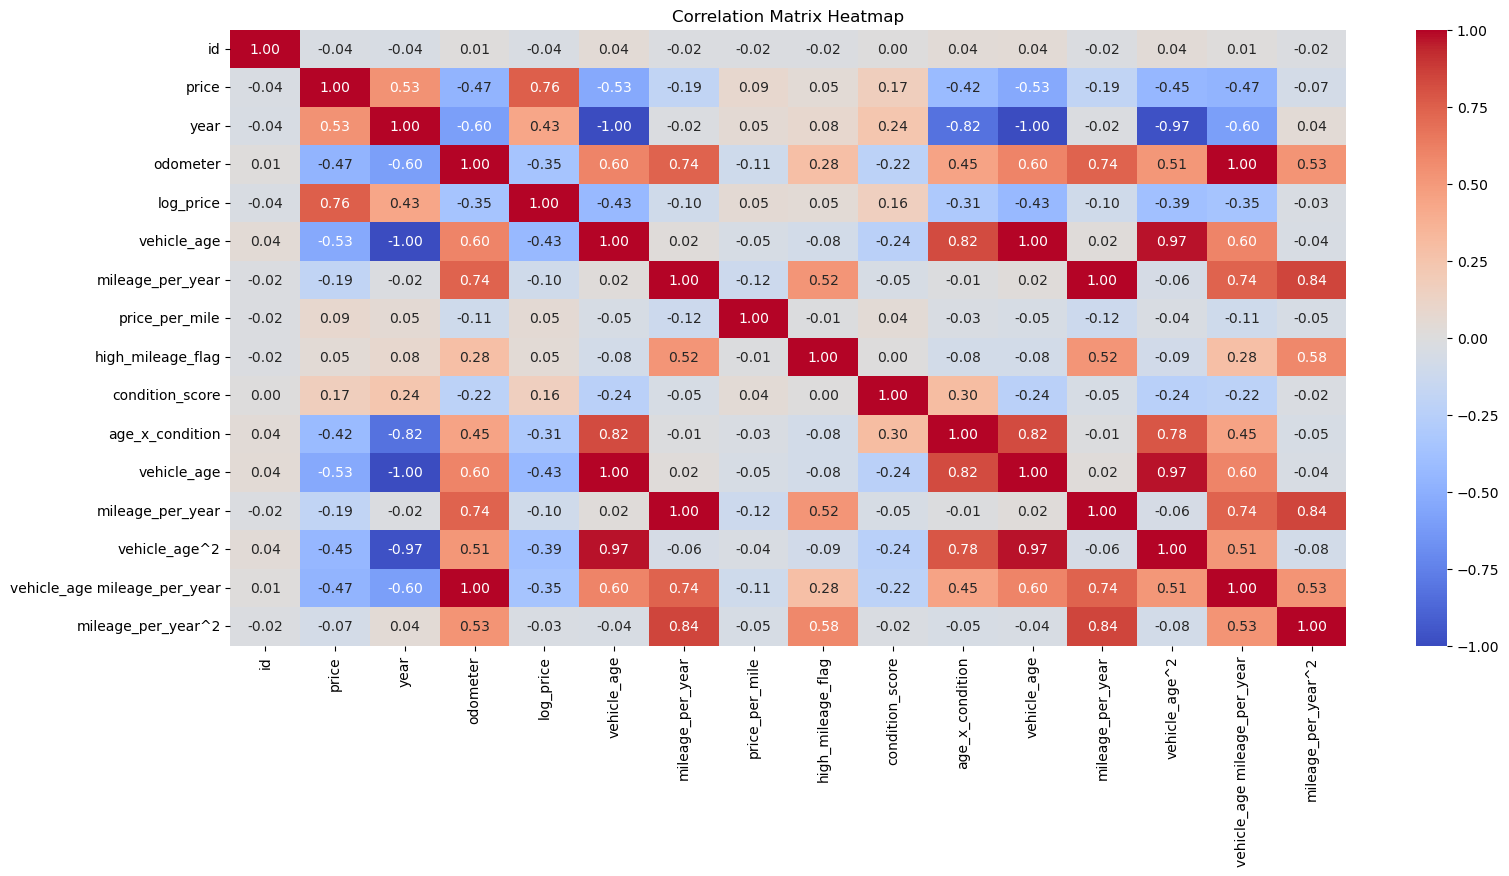

In [185]:
# Correlation matrix

numeric_df = cars_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [86]:
# Polynomial features
numeric_cols = ['vehicle_age', 'mileage_per_year']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(cars_df[numeric_cols])
poly_feature_names = poly.get_feature_names_out(numeric_cols)

# Creating a new dataframe with polynomial feature names
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=cars_df.index)

# Adding the polynomial features to the original dataframe
cars_df = pd.concat([cars_df, poly_df], axis=1)

# Final feature list. Original features and polynomial features
features = ['vehicle_age', 'mileage_per_year', 'condition_score', 'price_per_mile',
    'high_mileage_flag', 'age_x_condition'] + list(poly_feature_names) + ['fuel', 'transmission', 'type', 'state', 'age_bucket']

X = cars_df[features]
y = cars_df['log_price']

# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [89]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# After I tried the model with the whole set, I started getting errors because of null values. So, I am dropping any rows with 
# null values or invalid targets
valid_mask = (~y_train.isna()) & np.isfinite(y_train)
X_train_scaled = X_train_scaled[valid_mask]
y_train = y_train[valid_mask]

# I tried GridSearchCV with the whole set and it took 6 hours to complete. The readings were good, but the performance was awful.
# So, looking for alternatves to improve performance, RandomizedSearchCV and XGBoost regressor were suggested. 
# I tried it and the performance was significantly improved. It still takes a few minutes,
# but I will take a few minutes over 6 hours.

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)




Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

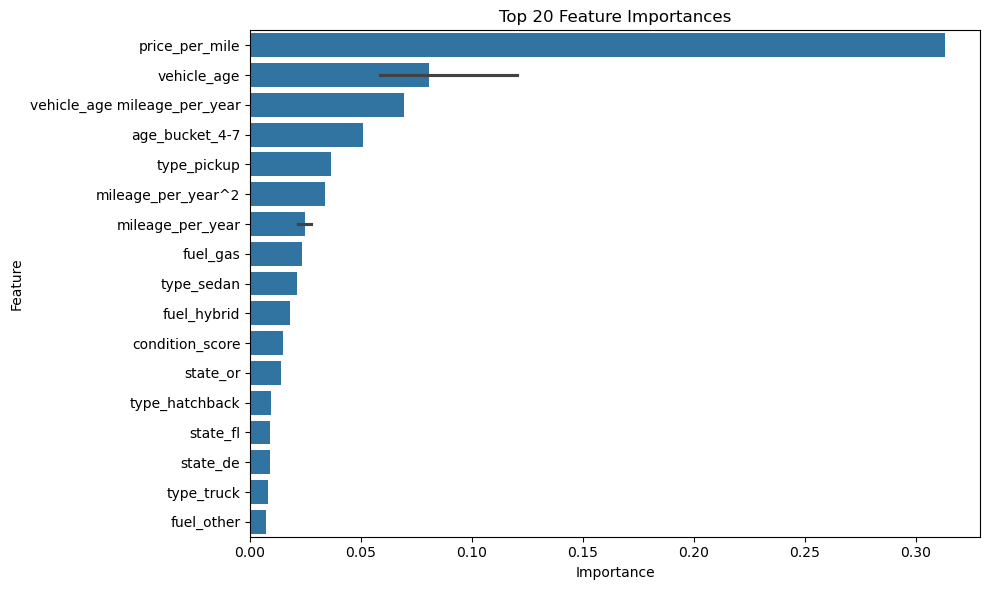

In [175]:
# Best model
best_xgb = random_search.best_estimator_

importances = best_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [163]:
#Cross Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = -cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')

print(f"Mean CV MSE: {cv_scores.mean():.2f}")
print(f"CV MSE Std Dev: {cv_scores.std():.2f}")

Mean CV MSE: 0.01
CV MSE Std Dev: 0.00


In [165]:
# Predictions
y_pred_log = best_xgb.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Metrics. Test Set Evaluation
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Mean Squared Error: 2469288.258164646
Mean Absolute Error: 506.69756037921263
R² Score: 0.9856327128300731


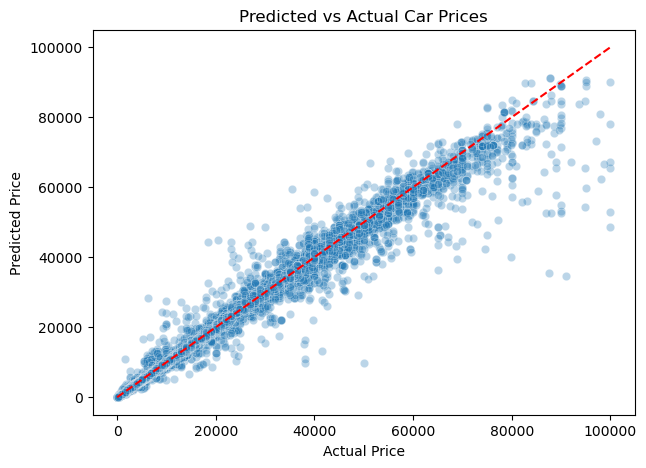

In [167]:
# Plot - Predicted vs Actual Prices
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Car Prices")
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [187]:
#I was finally able to get a high quality model, after removing the large categorical features.
# I tried countless models, going from no good metrics, to poor performance you name it. 
# This latest model, was trained on a cleaned and feature-engineered dataset with log-transformed prices and polynomial features, 
# it achieved strong predictive performance and by going from GridSearchCV to RandomizedGridSearch and XGBoost significantly 
# improved, both in accuracy and training speed.
#The results suggest the model is well-calibrated for price prediction and benefits from robust preprocessing and 
#hyperparameter tuning.
# A mean absolute error under $510 indicates that predictions are, on average, very close to actual car prices.
# R² = 0.985** suggests the model explains almost all the variance in car prices.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.